In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.metrics import mean_squared_error

In [2]:
# Read the movies CSV file and display the first few rows
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Count the total number of unique movies using the 'movieId'
total_number_of_movies = movies['movieId'].nunique()
print(total_number_of_movies)

9742


In [4]:
# Split the genres string into individual genres and explode the DataFrame
genres_split = movies['genres'].str.split('|').explode()
print(genres_split)

0       Adventure
0       Animation
0        Children
0          Comedy
0         Fantasy
          ...    
9738      Fantasy
9739        Drama
9740       Action
9740    Animation
9741       Comedy
Name: genres, Length: 22084, dtype: object


In [5]:
# Count the total number of genres in the dataset
total_number_of_genres = genres_split.nunique()
print(total_number_of_genres)

20


In [6]:
# Count the frequency of each genre in the movie dataset
genre_counts = genres_split.value_counts()
print(genre_counts)

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: genres, dtype: int64


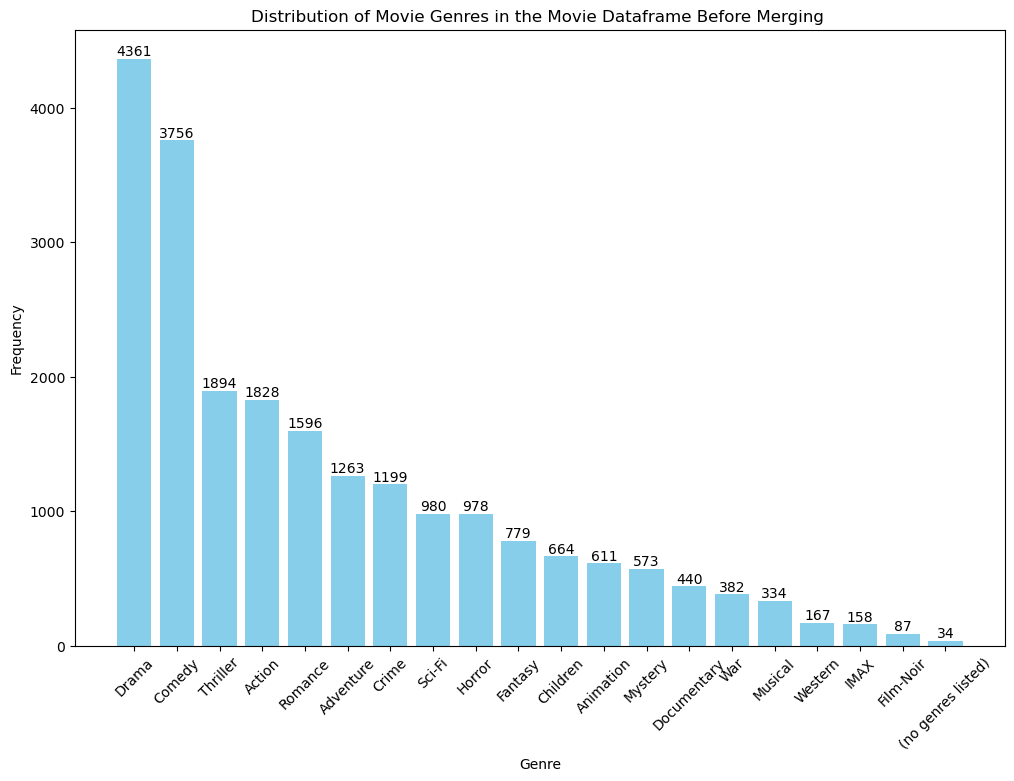

In [7]:
# Plot a graph showing the frequency distribution of movie genres
plt.figure(figsize=(12, 8))
bars = plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.title('Distribution of Movie Genres in the Movie Dataframe Before Merging ')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, yval, ha='center', va='bottom')
plt.show()

In [8]:
# Read and display the first five rows of the movie ratings dataset
movie_ratings = pd.read_csv("newratings.csv")
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# Display the total number of ratings in the movie rating dataset
total_number_of_ratings = movie_ratings['rating'].count()
print(total_number_of_ratings)

100836


In [10]:
# Count the frequency of each rating in the movie rating dataset
ratings_count = movie_ratings['rating'].value_counts()
print(ratings_count)

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


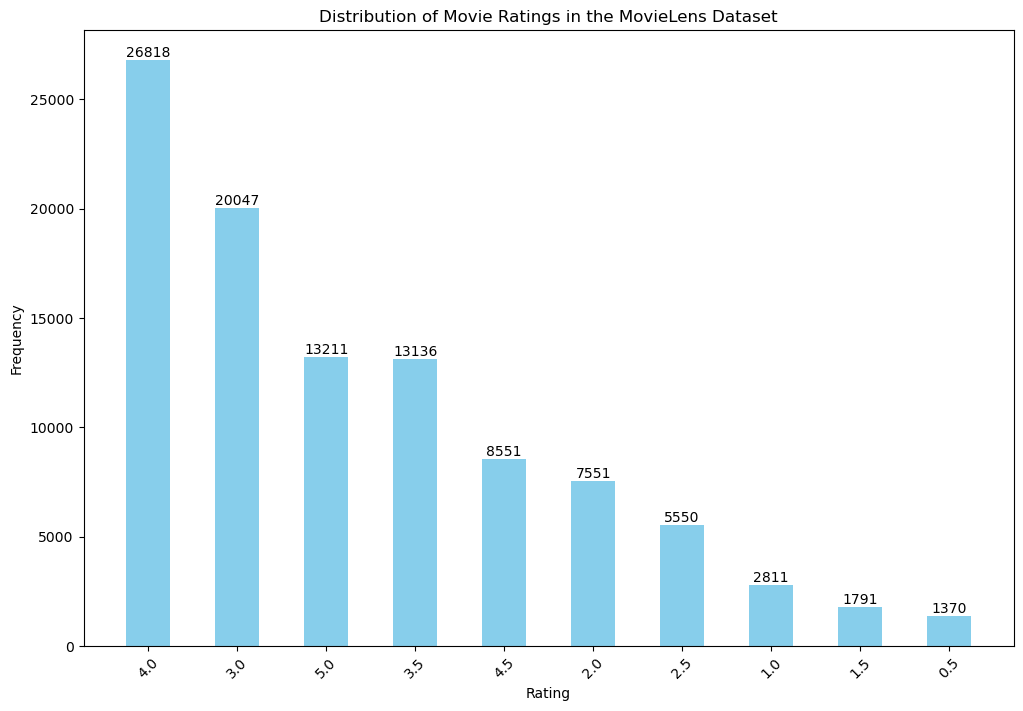

In [11]:
# Plot a graph of the movie rating distribution
x_pos = np.arange(len(ratings_count))
plt.figure(figsize=(12, 8))
bars = plt.bar(x_pos, ratings_count.values, width=0.5, color='skyblue')
plt.title('Distribution of Movie Ratings in the MovieLens Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(x_pos, ratings_count.index, rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, str(yval), ha='center', va='bottom')
plt.show()

In [12]:
# Print the total number of movies in the movie rating dataset
total_number_of_movies = movie_ratings['movieId'].nunique()
print(total_number_of_movies)

9724


There is a lower number of movies in the movie_ratings dataframe

In [13]:
# Print the total number of users in the movie rating dataset
total_number_of_users = movie_ratings['userId'].nunique()
print(total_number_of_users)

610


In [14]:
# Group the data by 'userId' and count the unique 'movieId's
unique_movies_per_user = movie_ratings.groupby('userId')['movieId'].nunique()
print(unique_movies_per_user)

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64


In [15]:
# Calculate the average number of movies each user rated
average_movies_rated_per_user = unique_movies_per_user.mean()
print(f"Average number of unique movies rated per user: {average_movies_rated_per_user}")

Average number of unique movies rated per user: 165.30491803278687


In [16]:
# Merge the movies dataset and movie ratings dataset for analysis
merged_movie_dataset = pd.merge(movies, movie_ratings, on='movieId')
merged_movie_dataset

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [17]:
# Check if there are any columns with missing values
columns_with_missing_values = merged_movie_dataset.columns[merged_movie_dataset.isnull().any()]
print(columns_with_missing_values)

Index([], dtype='object')


There are no columns with Missing Values when the movies and ratings dataframe is merged

In [18]:
# Drop duplicate rows
df_unique = merged_movie_dataset.drop_duplicates(keep=False)
df_unique

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [19]:
# Count the number of times each genre appears
genre_counts = genres_split.value_counts()
print(genre_counts)

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: genres, dtype: int64


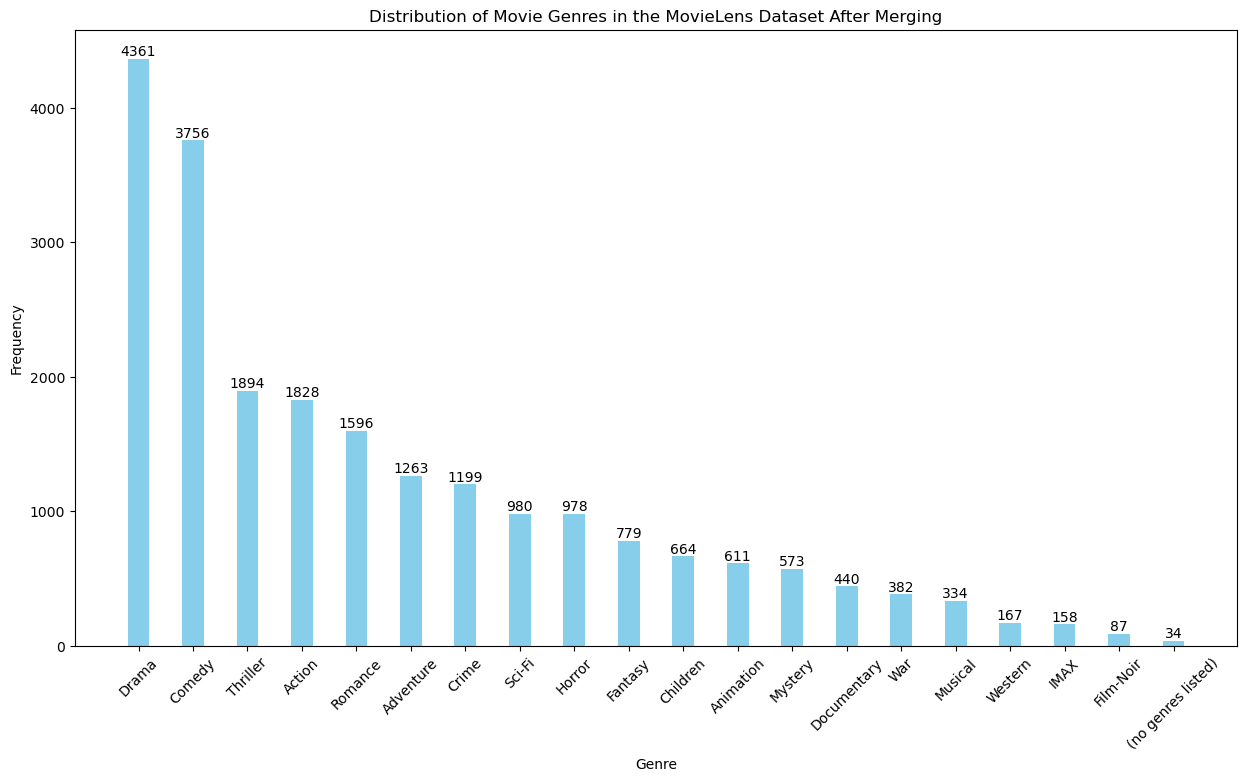

In [20]:
# Plot a bar chart to show the distribution of genres in the merged movie and rating dataframe
x_pos = np.arange(len(genre_counts)) * 2.0
plt.figure(figsize=(15, 8))
bars = plt.bar(x_pos, genre_counts.values, color='skyblue')
plt.title('Distribution of Movie Genres in the MovieLens Dataset After Merging')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(x_pos, genre_counts.index, rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, yval, ha='center', va='bottom')
plt.show()

By Merging the Movies and Movie Rating Dataframe, we can see how the movie genre action gets more popularity than thriller 
by displacing it and romance also displaces adventure to take the 5th most popular genre position. A look at the graph shows that several 
other movies either climb the popularity ladder or falls down.

In [21]:
# Calculate the average rating for each movie
average_ratings = df_unique.groupby('movieId')['rating'].mean()
print(average_ratings)


movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64


In [22]:
# Group the data by 'movieId', calculate the average rating and count the number of ratings for each movie
movie_stats = df_unique.groupby('movieId')['rating'].agg(['mean', 'count'])
movie_stats

,mean,count
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49
...,...,...
193581,4.000000,1
193583,3.500000,1
193585,3.500000,1


In [23]:
# Find the movie with the highest average rating
highest_average_rating = movie_stats['mean'].max()
movie_with_highest_average = movie_stats['mean'].idxmax()

In [24]:
# Retrieve the number of ratings for the movie with the highest average rating
number_of_ratings_for_highest_rated_movie = movie_stats.loc[movie_with_highest_average, 'count']
title_of_highest_average_rated_movie = df_unique[df_unique['movieId'] == highest_average_rating]['title'].iloc[0]
print(f"Movie with the highest average rating: {movie_with_highest_average}")
print(f"Highest average rating: {highest_average_rating}")
print(f"Number of ratings for the highest rated movie: {number_of_ratings_for_highest_rated_movie}")
print(f"The title of the movie with the highest average rating is: {title_of_highest_average_rated_movie}")

Movie with the highest average rating: 53
Highest average rating: 5.0
Number of ratings for the highest rated movie: 2
The title of the movie with the highest average rating is: Father of the Bride Part II (1995)


In [25]:
ratings_count_per_movie = df_unique.groupby('movieId')['rating'].count()

# Calculate the 90th percentile of the count of ratings per movie
m = ratings_count_per_movie.quantile(0.90)

# Calculate the average ratings again
average_ratings = df_unique.groupby('movieId')['rating'].agg(['mean', 'count'])

In [26]:
# Calculate the average rating across all movies (C)
C = df_unique['rating'].mean()

# Apply the weighted rating formula
average_ratings['weighted_rating'] = (average_ratings['count'] / (average_ratings['count'] + m) * average_ratings['mean']) + (m / (average_ratings['count'] + m) * C)

# Find the movie with the highest weighted average rating
highest_weighted_rating = average_ratings['weighted_rating'].max()
movie_with_highest_weighted_average = average_ratings['weighted_rating'].idxmax()

print(f"Movie with the highest weighted average rating: {movie_with_highest_weighted_average}")
print(f"Highest weighted average rating: {highest_weighted_rating}")

Movie with the highest weighted average rating: 318
Highest weighted average rating: 4.3562268562722615


In [27]:
number_of_ratings_for_movie_with_highest_weighted_rated = movie_stats.loc[movie_with_highest_weighted_average, 'count']

number_of_ratings_for_movie_with_highest_weighted_rated

317

In [28]:
# Locate the title of the movie with the highest average rating
title_of_highest_rated_movie = df_unique[df_unique['movieId'] == movie_with_highest_weighted_average]['title'].iloc[0]

print(f"The title of the movie with the highest average rating: {title_of_highest_rated_movie} with {number_of_ratings_for_movie_with_highest_weighted_rated} ratings")


The title of the movie with the highest average rating: Shawshank Redemption, The (1994) with 317 ratings


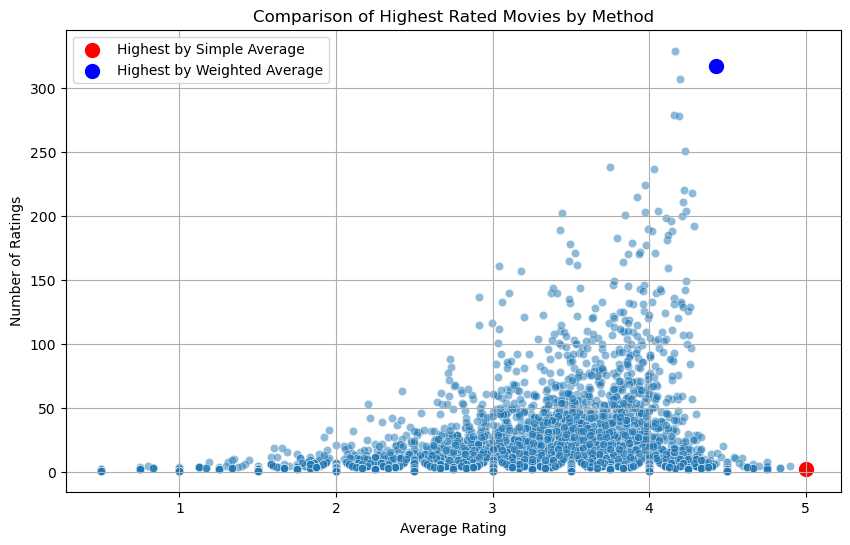

In [29]:
'''Given the 'average_ratings' DataFrame contains 'mean', 'count', and 'weighted_rating' for each movie
And assuming you have the 'highest_average_rating', 'movie_with_highest_average', 'highest_weighted_rating', 
and 'movie_with_highest_weighted_average' variables set from your methods'''

# Plotting all movies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=average_ratings['mean'], y=average_ratings['count'], alpha=0.5)

# Highlighting the highest-rated movie by simple average
plt.scatter(average_ratings.loc[movie_with_highest_average, 'mean'], average_ratings.loc[movie_with_highest_average, 'count'], color='red', s=100, label='Highest by Simple Average')

# Highlighting the highest-rated movie by weighted average
plt.scatter(average_ratings.loc[movie_with_highest_weighted_average, 'mean'], average_ratings.loc[movie_with_highest_weighted_average, 'count'], color='blue', s=100, label='Highest by Weighted Average')

plt.title('Comparison of Highest Rated Movies by Method')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Calculate the number of ratings per movie
ratings_count = df_unique.groupby('movieId').size()

In [31]:
# Sort the movies by the number of ratings in descending order
sorted_ratings_count = ratings_count.sort_values(ascending=False)

# Create a rank for each movie based on number of ratings
ranks = range(1, len(sorted_ratings_count) + 1)

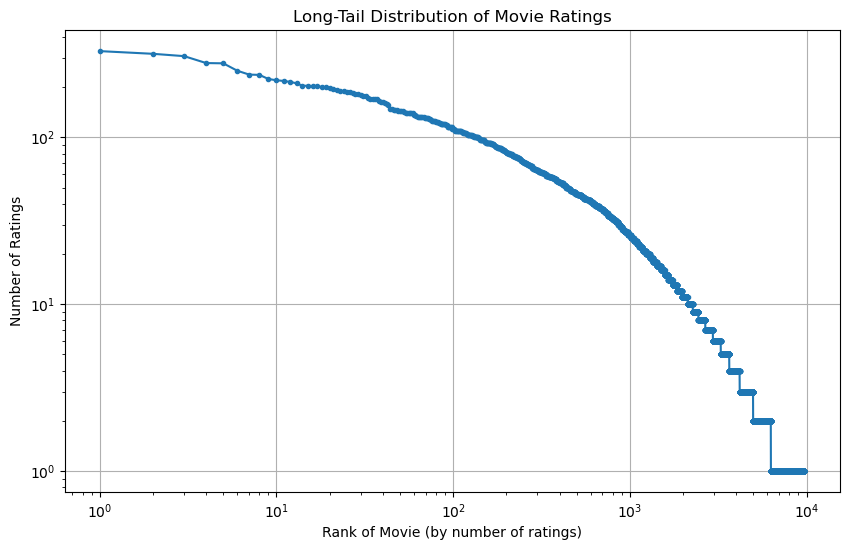

In [32]:
# Plotting the long-tail graph
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_ratings_count, marker='.')
plt.title('Long-Tail Distribution of Movie Ratings')
plt.xlabel('Rank of Movie (by number of ratings)')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

In the above graph the long tail distribution which is common with many rating systems is displayed, 
which is proof that a large number of users will leave for the popular movies more leaving the less popular
movies with little to no ratings

In [33]:
# Read the tags cvs file as it will be used in creating the metadata
df_tags = pd.read_csv('tags.csv')
df_tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [34]:
# Concatenate genres and tags to create metadata for each movie
movies['metadata'] = movies['genres'].astype(str) + '|' + movies.merge(df_tags, on='movieId', how='left')['tag'].fillna('').astype(str)

movies

,movieId,title,genres,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure|Children|Fantasy|pixar
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy|Romance|fun
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy|Drama|Romance|fantasy
4,5,Father of the Bride Part II (1995),Comedy,Comedy|magic board game
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Action|Animation|Comedy|Fantasy|
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Animation|Comedy|Fantasy|
9739,193585,Flint (2017),Drama,Drama|
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Action|Animation|


In [35]:
# Merge the movies dataset and movie ratings dataset to aid in building the proposed recommendation model and further analysis
df_unique = merged_movie_dataset.drop_duplicates(keep=False)
df_unique

Mergedmoviedataset = pd.merge(movies, movie_ratings, on='movieId')
Mergedmoviedataset



,movieId,title,genres,metadata,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,17,4.5,1305696483
...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Action|Animation|Comedy|Fantasy|,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Animation|Comedy|Fantasy|,184,3.5,1537109545
100833,193585,Flint (2017),Drama,Drama|,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Action|Animation|,184,3.5,1537110021


In [36]:
# Handle the popularity bias by identifing movies to downsample (e.g., those in the top 10% of popularity)
top_10_percent_threshold = ratings_count.quantile(0.8)
popular_movies = ratings_count[ratings_count > top_10_percent_threshold].index

In [37]:
# Downsample ratings from these popular movies
downsampled_df = Mergedmoviedataset[Mergedmoviedataset['movieId'].isin(popular_movies)]
downsampled_df

,movieId,title,genres,metadata,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Children|Comedy|Fantasy|pixar,17,4.5,1305696483
...,...,...,...,...,...,...,...
100631,177765,Coco (2017),Adventure|Animation|Children,Adventure|Animation|Children|,338,2.5,1530148369
100632,177765,Coco (2017),Adventure|Animation|Children,Adventure|Animation|Children|,459,5.0,1520232994
100633,177765,Coco (2017),Adventure|Animation|Children,Adventure|Animation|Children|,567,1.5,1525282058
100634,177765,Coco (2017),Adventure|Animation|Children,Adventure|Animation|Children|,586,4.0,1529899170


In [38]:
# Splitting the DataFrame into features and the target variable
unique_movieId = downsampled_df['movieId'].unique()

# Splitting the unique movie IDs into train and test sets to prevent overfitting during recommendation
train_movie, test_movie = train_test_split(unique_movieId, test_size=0.2, random_state=42)

# Creating the training set by selecting rows with movie IDs in train_movie_ids
train = downsampled_df[downsampled_df['movieId'].isin(train_movie)]

# Creating the training set by selecting rows with movie IDs in train_movie_ids
test = downsampled_df[downsampled_df['movieId'].isin(test_movie)]


In [39]:
# Converting the 'movie_id' columns from both datasets to sets to verify they are unique
train_movie = set(train['movieId'].unique())
test_movie = set(test['movieId'].unique())

# Finding the intersection of the two sets
intersection = train_movie.intersection(test_movie)

# Checking if the intersection is empty
if not intersection:
    print("The reserved and non-reserved datasets are unique; there are no overlapping movie IDs.")
else:
    print(f"The reserved and non-reserved datasets have overlapping movie IDs: {intersection}")

The reserved and non-reserved datasets are unique; there are no overlapping movie IDs.


***TWO CONTENT BASED RECOMMENDATION MODELS(MULTILABELBINARIZER AND TFIDFVECTORIZER)***

In [40]:
# # '''using the newly created metadata column in df_unique where each entry is a list or a string of genres separated by '|'
# # to create a cosine similarity matrix'''

# mlb = MultiLabelBinarizer()
# metadata_matrix1 = mlb.fit_transform(train['genres'].str.split('|'))

# cosine_similarity_matrix = cosine_similarity(metadata_matrix1)

In [41]:
# Vectorizing the metadata to create a numeric feature matrix
tfidf = TfidfVectorizer(stop_words='english')
metadata_matrix = tfidf.fit_transform(movies['genres'])
# Calculating the cosine similarity on the metadata matrix
cosine_sim = cosine_similarity(metadata_matrix)

In [42]:
def get_recommendations_by_movie_id(input_movie_id, movies, cosine_sim):
    # Checking if the input_movie_id exists in the movies_df
    if input_movie_id not in movies['movieId'].values:
        return "Movie ID not found."
    
    # Geting the title of the movie corresponding to the input_movie_id
    input_movie_title = movies.loc[movies['movieId'] == input_movie_id, 'title'].iloc[0]
    
    # Getting the index of the movie that matches the input_movie_id
    idx = movies.index[movies['movieId'] == input_movie_id].tolist()[0]
    
    # Getting the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim [idx]))
    
    # Sorting the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Getting the scores of the top 10 most similar movies
    sim_scores = sim_scores[1:11]  # Exclude the first one since it's the input movie itself
    
    # Getting the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Prepare the output
    recommended_movies = movies.iloc[movie_indices][['movieId', 'title']]
    
    # Printing the input movie title
    print(f"Recommendations for movie ID {input_movie_id} - '{input_movie_title}':")
    
    # Returning the recommended movie IDs and titles
    return recommended_movies

# movies_df = pd.DataFrame({
#     'movieId': [1],
#     'title': ['Toy Story (1995)']
# })

# cosine_sim_matrix of the precomputed cosine similarity matrix
input_movie_id = 44
recommended_movies = get_recommendations_by_movie_id(input_movie_id, movies, cosine_sim)
recommended_movies

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':


,movieId,title
349,393,Street Fighter (1994)
549,653,Dragonheart (1996)
974,1275,Highlander (1986)
1190,1587,Conan the Barbarian (1982)
1266,1681,Mortal Kombat: Annihilation (1997)
1576,2115,Indiana Jones and the Temple of Doom (1984)
1644,2193,Willow (1988)
1775,2373,Red Sonja (1985)
2126,2826,"13th Warrior, The (1999)"
2376,3153,"7th Voyage of Sinbad, The (1958)"


***EVALUATING THE PERFORMANCE OF THE CONTENT BASED BINARIZER MODEL AND THE VECTORIZER MODEL BY COMPARING THEIR INTRALIST SIMILARITY SCORE***

In [43]:
import numpy as np

def calculate_intralist_similarity(recommended_indices, cosine_similarity_matrix):
    # Creating a matrix to hold the pairwise similarity scores
    similarity_scores = cosine_similarity_matrix[recommended_indices, :][:, recommended_indices]
    
    # Getting the upper triangle of the matrix, excluding the diagonal (self-similarity)
    upper_triangle_indices = np.triu_indices(len(recommended_indices), k=1)
    upper_triangle_scores = similarity_scores[upper_triangle_indices]
    
    # Calculating the average similarity score for the upper triangle
    ils_score = np.mean(upper_triangle_scores)
    
    return ils_score

In [44]:
# Assuming 'recommended_movies' is the DataFrame obtained from your recommendation function
recommended_indices = recommended_movies.index.tolist()

In [45]:
# Assuming 'cosine_similarity_matrix' is your precomputed cosine similarity matrix
ils_score = calculate_intralist_similarity(recommended_indices, cosine_sim)

In [46]:
print(f"The Intra-List Similarity score for the recommendations is: {ils_score}")

The Intra-List Similarity score for the recommendations is: 1.0


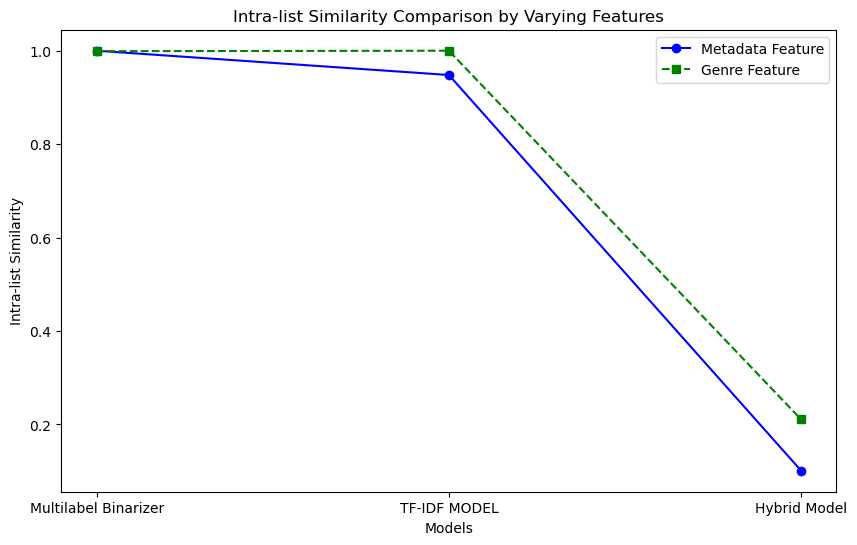

In [47]:
# Sample data: Intra-list similarity scores for two features across two models
scores_metadata = [1.0000000000000002, 0.948, 0.10084000189491156]  # Scores with metadata feature
scores_genre = [0.999, 1.0, 0.21052121755543254]  # Scores with genre feature

# Names of the models
models = ['Multilabel Binarizer', 'TF-IDF MODEL', "Hybrid Model"]

# X-axis positions for each model
x_positions = range(len(models))

# Plotting the line graph
plt.figure(figsize=(10, 6))

# Plotting the lines for each feature
plt.plot(x_positions, scores_metadata, marker='o', linestyle='-', color='blue', label='Metadata Feature')
plt.plot(x_positions, scores_genre, marker='s', linestyle='--', color='green', label='Genre Feature')

# Adding title and labels
plt.title('Intra-list Similarity Comparison by Varying Features')
plt.ylabel('Intra-list Similarity')
plt.xlabel('Models')

# Setting the position of the x ticks and their labels
plt.xticks(x_positions, models)

# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

***TRAINING THE COLLABORATIVE MODEL***

In [48]:
# Creating a pivot table with users as rows, movies as columns, and ratings as values
interaction_matrix_train = train.pivot(index='userId', columns='movieId', values='rating')

# Filling missing values with zeros, since we're going to convert this to a sparse matrix
interaction_matrix_train = interaction_matrix_train.fillna(0)

In [49]:
# metadata_matrix_sparse = csr_matrix(metadata_matrix)
interaction_matrix_train_sparse = csr_matrix(interaction_matrix_train.values)

In [50]:
# Creating the user-item interaction matrix from the training data
interaction_matrix_train = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)


In [51]:
# Creating a sparse matrix from the DataFrame
interaction_matrix_train_sparse = csr_matrix(interaction_matrix_train)

In [52]:
# Performing SVD on the interaction matrix
U, sigma, Vt = svds(interaction_matrix_train_sparse, k= 5)  # k is the number of latent factors

# Converting  sigma to a diagonal matrix
sigma = np.diag(sigma)

In [53]:
#Training the model to make predictions
predicted_ratings_train = np.dot(np.dot(U, sigma), Vt)

In [54]:
'''Creating a function that recommends movies to users by taking the user ratings of movies 
    interacted with and the predicted ratings on the trained model'''

def recommend_items_train(user_id, user_ratings, predicted_ratings_train, num_recommendations=5):
    # Ensure user_id corresponds to the index in the predicted_ratings matrix
    user_idx = np.where(interaction_matrix_train.index == user_id)[0][0]  # Convert user_id to index
    
    # Get the indices of the movies that the user has not rated
    unrated_movies_mask = user_ratings == 0
    unrated_movies_indices = np.where(unrated_movies_mask)[0]
    
    # Predict ratings for unrated movies using positional indices
    predicted_scores = predicted_ratings_train[user_idx, unrated_movies_indices]
    
    # Get the indices of the top predicted ratings
    top_movie_indices = np.argsort(-predicted_scores)[:num_recommendations]
    
    # Map the positional indices back to movie IDs
    recommended_movie_ids_train = interaction_matrix_train.columns[top_movie_indices]
    
    return recommended_movie_ids_train

In [55]:
user_id = 590
user_ratings = interaction_matrix_train.loc[user_id]
recommended_movie_ids_train = recommend_items_train(user_id, user_ratings, predicted_ratings_train)
print("Recommended Movie IDs:", recommended_movie_ids_train)

Recommended Movie IDs: Int64Index([1135, 1635, 1019, 628, 1729], dtype='int64', name='movieId')


In [56]:
#Creating a function that maps the recommended movieIds to the movie titles
def map_movie_ids_to_titles(movie_ids, train):
    """
    Maps a list of movieIds to their corresponding movie titles.
    
    Parameters:
    movie_ids (list of int): The list of movieIds to map.
    movies_df (DataFrame): The DataFrame containing movieId and title columns.
    
    Returns:
    list of str: The list of movie titles corresponding to the movieIds.
    """
    movie_titles = []
    for movie_id in movie_ids:
        title_row = train[train['movieId'] == movie_id]
        if not title_row.empty:
            movie_titles.append(title_row.iloc[0]['title'])
        else:
            movie_titles.append("Title not found for MovieId: {}".format(movie_id))
    return movie_titles

recommended_movie_titles = map_movie_ids_to_titles(recommended_movie_ids_train, train)

# Display the recommended movie titles
print("Recommended Movie Titles:")
for title in recommended_movie_titles:
    print(title)

Recommended Movie Titles:
Private Benjamin (1980)
Ice Storm, The (1997)
20,000 Leagues Under the Sea (1954)
Primal Fear (1996)
Jackie Brown (1997)


***TESTING THE DEVELOPED COLLABORATION MODEL***

In [57]:
interaction_matrix =  downsampled_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)


In [58]:
#Creating the user-item interaction matrix from the training data
interaction_matrix_test =  test.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [59]:
interaction_matrix_test_sparse = csr_matrix(interaction_matrix_test)

# Perform SVD on the interaction matrix
U, sigma, Vt = svds(interaction_matrix_test_sparse, k= 100)  # k is the number of latent factors

# Convert sigma to a diagonal matrix
sigma_test = np.diag(sigma)

In [60]:
predicted_ratings_test = np.dot(np.dot(U, sigma_test), Vt)

In [61]:
def recommend_items_test(user_id, user_ratings, predicted_ratings_test, num_recommendations=5):
    # Ensure user_id corresponds to the index in the predicted_ratings matrix
    user_idx = np.where(interaction_matrix_test.index == user_id)[0][0]  # Convert user_id to index
    
    # Get the indices of the movies that the user has not rated
    unrated_movies_mask = user_ratings == 0
    unrated_movies_indices = np.where(unrated_movies_mask)[0]
    
    # Predict ratings for unrated movies using positional indices
    predicted_scores = predicted_ratings_test[user_idx, unrated_movies_indices]
    
    # Get the indices of the top predicted ratings
    top_movie_indices = np.argsort(-predicted_scores)[:num_recommendations]
    
    # Map the positional indices back to movie IDs
    recommended_movie_ids_test = interaction_matrix_test.columns[top_movie_indices]
    
    return recommended_movie_ids_test.tolist()

user_id = 590
user_ratings = interaction_matrix_test.loc[user_id]
recommended_movie_ids_test = recommend_items_test(user_id, user_ratings, predicted_ratings_test)
print("Recommended Movie IDs:", recommended_movie_ids_test)

Recommended Movie IDs: [1663, 852, 1283, 1303, 2995]


In [62]:
def map_movie_ids_to_titles(movie_ids, test):
    """
    Maps a list of movieIds to their corresponding movie titles.
    
    Parameters:
    movie_ids (list of int): The list of movieIds to map.
    movies_df (DataFrame): The DataFrame containing movieId and title columns.
    
    Returns:
    list of str: The list of movie titles corresponding to the movieIds.
    """
    movie_titles = []
    for movie_id in movie_ids:
        title_row = test[ test['movieId'] == movie_id]
        if not title_row.empty:
            movie_titles.append(title_row.iloc[0]['title'])
        else:
            movie_titles.append("Title not found for MovieId: {}".format(movie_id))
    return movie_titles

recommended_movie_titles = map_movie_ids_to_titles(recommended_movie_ids_test, test)


# Display the recommended movie titles
print("Recommended Movie Titles:")
for title in recommended_movie_titles:
    print(title)
    


Recommended Movie Titles:
Stripes (1981)
Tin Cup (1996)
High Noon (1952)
Man Who Would Be King, The (1975)
House on Haunted Hill (1999)


In [63]:
#Creating a function to get all movies that are relevant to a user based on a defined rating threshold

def get_all_users_actual_relevant_items(interaction_matrix, rating_threshold=4.0):
    all_relevant_items = {}
    
    for user_id in interaction_matrix.index:
        user_ratings = interaction_matrix.loc[user_id]
        relevant_movies = user_ratings[user_ratings >= rating_threshold].index.tolist()
        all_relevant_items[user_id] = relevant_movies
        
        # Print the relevant items for the current user
        print(f"User {user_id} relevant items: {relevant_movies}")
    
    return all_relevant_items



In [64]:
all_users_actual_relevant_items = get_all_users_actual_relevant_items(interaction_matrix)


User 1 relevant items: [1, 3, 6, 47, 50, 101, 110, 151, 163, 216, 231, 235, 260, 333, 349, 356, 362, 367, 441, 457, 480, 527, 543, 552, 553, 590, 592, 593, 596, 608, 661, 733, 919, 923, 954, 1023, 1025, 1029, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1220, 1222, 1224, 1240, 1256, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1500, 1517, 1552, 1573, 1587, 1617, 1620, 1625, 1732, 1777, 1805, 1920, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2046, 2054, 2058, 2078, 2090, 2094, 2096, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2268, 2273, 2291, 2329, 2353, 2366, 2387, 2395, 2406, 2427, 2450, 2459, 2470, 2478, 2502, 2529, 2542, 2571, 2580, 2616, 2628, 2640, 2641, 2692, 2700, 2716, 2761, 2797, 2826, 2858, 2872, 2916, 2944, 2947, 2948, 2949, 2959, 2985, 2987, 2991, 2993, 2997, 3033, 3034, 3052, 3147, 3168, 3253, 3273, 3386, 3439, 3440, 3441, 3448, 3450, 3479, 3489, 3527, 3578, 3617, 3639, 3671,

User 244 relevant items: [6, 10, 110, 151, 349, 356, 368, 377, 380, 457, 541, 555, 589, 593, 648, 786, 1049, 1079, 1090, 1196, 1197, 1200, 1215, 1225, 1228, 1233, 1242, 1270, 1288, 1293, 1356, 1370, 1377, 1408, 1527, 1580, 1586, 1597, 1610, 1754, 1957, 2028, 2490, 2571, 2716, 2791, 2797, 3082, 3256, 3300, 3361, 3578, 3703, 3755]
User 245 relevant items: [246, 3114]
User 246 relevant items: [17, 29, 50, 163, 235, 260, 293, 296, 357, 410, 541, 589, 616, 714, 838, 910, 1196, 1210, 1240, 1243, 1246, 1298, 1304, 1527, 1625, 1645, 1680, 1884, 2020, 2046, 2124, 2336, 2396, 2571, 2671, 2805, 2916, 2959, 3081, 3108, 3863, 3996, 4011, 4144, 4226, 4246, 4270, 4720, 4848, 4881, 4886, 4896, 4963, 4973, 4993, 5013, 5618, 5902, 5952, 5971, 6350, 6365, 6377, 6539, 6618, 6773, 6874, 6934, 6942, 7022, 7090, 7099, 7147, 7153, 7361, 7373, 7438, 8865, 8970, 8983, 8984, 26662, 26776, 30793, 31658, 31878, 32587, 33615, 40815, 44191, 44665, 45517, 45722, 48394, 49272, 53125, 55820, 57669, 59315, 59784, 60069,

User 329 relevant items: [778, 1193, 1237, 1258, 1292, 1884, 1958]
User 330 relevant items: [1, 25, 32, 50, 58, 141, 208, 223, 231, 253, 260, 288, 296, 300, 316, 318, 350, 353, 356, 370, 497, 551, 553, 555, 562, 590, 592, 593, 597, 608, 750, 778, 858, 919, 1028, 1035, 1073, 1080, 1097, 1136, 1193, 1196, 1197, 1200, 1206, 1207, 1210, 1214, 1222, 1225, 1246, 1258, 1259, 1265, 1266, 1270, 1278, 1288, 1299, 1358, 1387, 1391, 1394, 1517, 1527, 1580, 1639, 1673, 1676, 1732, 1784, 1923, 1961, 1968, 2174, 2291, 2324, 2329, 2502, 2657, 2700, 2710, 2712, 2716, 2762, 2788, 2791, 2797, 2858, 2871, 2916, 2918, 2959, 2987, 2997, 3052, 3147, 3471, 3578, 3793, 3948, 3949, 3996, 4011, 4022, 4034, 4226, 4306, 4878, 4886, 4896, 5013, 5378, 5952, 5989, 6333, 6377, 6874, 7153, 7387, 7438, 8874, 8961, 48516, 48738, 58559, 60069, 61240, 64614, 68157, 70286, 71535, 79132, 79702]
User 331 relevant items: [50, 293, 296, 318, 593, 608, 858, 1136, 1213, 1676, 2712, 2959, 3535, 3578, 3751, 3897, 3911, 3969, 4223, 

User 448 relevant items: [1, 10, 16, 47, 50, 107, 145, 161, 165, 223, 260, 296, 300, 329, 348, 349, 377, 410, 457, 471, 474, 485, 492, 500, 541, 543, 555, 585, 593, 594, 596, 608, 616, 671, 720, 745, 778, 785, 858, 912, 919, 923, 924, 1020, 1022, 1028, 1030, 1031, 1032, 1035, 1036, 1037, 1073, 1077, 1079, 1080, 1089, 1090, 1092, 1097, 1125, 1136, 1148, 1171, 1193, 1196, 1198, 1201, 1206, 1208, 1209, 1210, 1213, 1221, 1223, 1227, 1228, 1230, 1234, 1244, 1250, 1256, 1262, 1265, 1266, 1270, 1275, 1276, 1283, 1288, 1291, 1304, 1343, 1356, 1387, 1391, 1393, 1396, 1405, 1476, 1517, 1580, 1610, 1614, 1617, 1620, 1639, 1641, 1676, 1704, 1722, 1729, 1784, 1920, 1923, 1953, 1954, 2000, 2003, 2012, 2013, 2018, 2019, 2054, 2060, 2083, 2087, 2090, 2105, 2110, 2115, 2194, 2231, 2243, 2268, 2289, 2300, 2335, 2355, 2366, 2378, 2393, 2407, 2463, 2470, 2474, 2542, 2567, 2657, 2683, 2694, 2700, 2716, 2723, 2762, 2770, 2788, 2791, 2797, 2857, 2858, 2881, 2915, 2918, 2947, 2948, 2949, 2951, 2959, 2968, 297

***EVALUATING THE PERFORMANCE OF THE BUILT COLLABORATIVE FILTERING RECOMMENDER MODEL***

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Flatten the actual and predicted ratings into vectors
actual_ratings_vector = interaction_matrix_test.values.flatten()
predicted_ratings_vector = predicted_ratings_train.flatten()

# Create a mask for non-zero actual ratings
non_zero_mask = actual_ratings_vector.nonzero()

# Filter out zero entries from both actual and predicted ratings
actual_ratings_non_zero = actual_ratings_vector[non_zero_mask]
predicted_ratings_non_zero = predicted_ratings_vector[non_zero_mask]

# Calculate RMSE only on non-zero actual ratings
rmse = sqrt(mean_squared_error(actual_ratings_non_zero, predicted_ratings_non_zero))
print(f"RMSE: {rmse}")

RMSE: 3.547143545705869


In [66]:
def calculate_mapk(test_users, interaction_matrix, predicted_ratings, k=10, rating_threshold=4.0):
    """
    Calculates the Mean Average Precision at K (MAP@K) for the collaborative filtering model.
    
    Parameters:
    test_users (list): List of user IDs in the test set.
    interaction_matrix (DataFrame): The user-item interaction matrix.
    predicted_ratings (ndarray): The matrix of predicted ratings.
    k (int): Number of top recommendations to consider for each user.
    rating_threshold (float): The threshold rating above which movies are considered relevant.
    
    Returns:
    float: The MAP@K score for the model.
    """
    ap_scores = []
    
    for user_id in test_users:
        user_ratings = interaction_matrix.loc[user_id]
        recommended_movie_ids = recommend_items_test(user_id, user_ratings, predicted_ratings_train, k)
        actual_relevant_items = all_users_actual_relevant_items[user_id]
        
        # Calculate AP@K
        hits = 0
        precision_at_i = 0
        for i, rec_movie_id in enumerate(recommended_movie_ids, start=1):
            if rec_movie_id in actual_relevant_items:
                hits += 1
                precision_at_i += hits / i
        
        if hits > 0:
            ap_scores.append(precision_at_i / min(len(actual_relevant_items), k))
        else:
            ap_scores.append(0)
    
    # Calculate MAP@K
    mapk = sum(ap_scores) / len(ap_scores)
    return mapk


test_users = interaction_matrix_test.index.tolist()  # Assuming this is how you get your list of test users
mapk_score = calculate_mapk(test_users, interaction_matrix_test, predicted_ratings_train, k=10)
print(f"MAP@K Score: {mapk_score}")

MAP@K Score: 0.016855353890189946


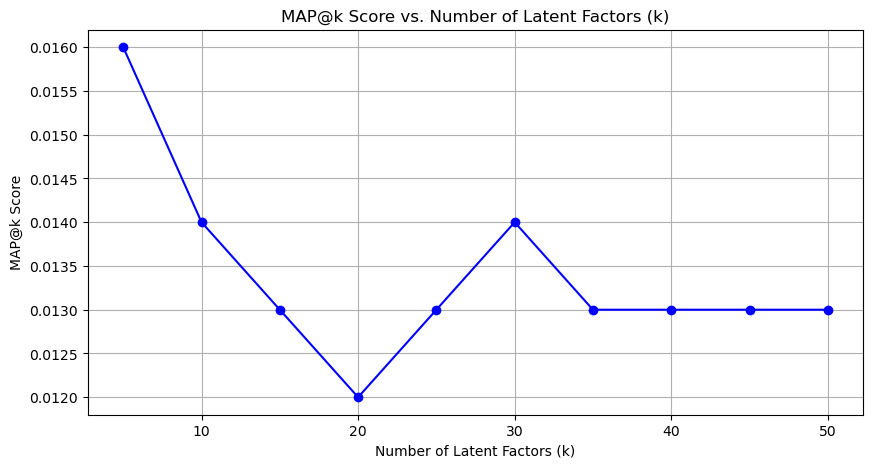

In [67]:
import matplotlib.pyplot as plt

# Example data: lists of k values and their corresponding MAP@k scores
# Replace these with your actual values
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
map_at_k_scores = [0.016, 0.014, 0.013, 0.012, 0.013, 0.014, 0.013, 0.013, 0.013, 0.013]

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(k_values, map_at_k_scores, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('MAP@k Score vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('MAP@k Score')

plt.grid(True)

# Show the plot
plt.show()

In [68]:
def weighted_hybrid_recommendation(cf_recommendations, cb_recommendations, weight_cf, weight_cb):
    # Combine recommendations
    combined_scores = {}
    for item, score in cf_recommendations.items():
        combined_scores[item] = score * weight_cf
    for item, score in cb_recommendations.items():
        if item in combined_scores:
            combined_scores[item] += score * weight_cb
        else:
            combined_scores[item] = score * weight_cb
    
    # Sort items based on combined scores
    sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_recommendations

In [69]:
def hybrid_recommendation(user_id, input_movie_id, movies, cosine_sim, interaction_matrix_test, predicted_ratings_test, k, weight_cf=0.5, weight_cb=0.5):
    # Generate collaborative filtering recommendations
    user_ratings = interaction_matrix_test.loc[user_id]
    cf_recommendations = recommend_items_test(user_id, user_ratings, predicted_ratings_test, num_recommendations=k)
    
    # Generate content-based recommendations
    cb_recommendations_df = get_recommendations_by_movie_id(input_movie_id, movies, cosine_sim)
    cb_recommendations = cb_recommendations_df['movieId'].tolist()
    
    # Apply weights to the recommendations
    combined_scores = {}
    for movie_id in cf_recommendations:
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + weight_cf
    for movie_id in cb_recommendations:
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + weight_cb
    
    # Sort combined recommendations based on weighted scores
    sorted_combined_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Extract the movie IDs from the sorted list of tuples
    sorted_movie_ids = [movie_id for movie_id, score in sorted_combined_recommendations]
    
    # Limit the number of recommendations to the top k items
    top_k_recommendations = sorted_movie_ids[:k]
    
    return top_k_recommendations

user_id = 44
input_movie_id = 44
movies = movies
cosine_sim = cosine_sim
interaction_matrix_test = interaction_matrix_test
predicted_ratings_test = predicted_ratings_test
k = 10  # Number of recommendations to return

# Call the hybrid_recommendation function
top_k_recommendations = hybrid_recommendation(user_id, input_movie_id, movies, cosine_sim, interaction_matrix_test, predicted_ratings_test, k)

# Print the results
print("Top", k, "recommendations:", top_k_recommendations)

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Top 10 recommendations: [653, 719, 608, 1022, 969, 76, 1566, 1214, 671, 1726]


In [70]:
def calculate_precision_at_k_all_users(interaction_data, k, hybrid_recommendation, get_all_users_actual_relevant_items):
    """
    Calculate the Precision@k for all users in the dataset given a hybrid recommendation function.
    
    Parameters:
    - interaction_data: A DataFrame containing user interactions, used to extract all unique user IDs.
    - k: The number of top recommendations to consider.
    - hybrid_recommendation: The function used to generate recommendations.
    - all_users_actual_relevant_items: A function that takes a user_id and returns a list of actual relevant movie IDs for that user.
    
    Returns:
    - The average Precision@k across all users in the dataset.
    """
    # Extract all unique user IDs from the interaction data
    user_ids = downsampled_df['userId'].unique()
    
    precisions = []
    
    for user_id in user_ids:
        # Generate top-k recommendations for the user
        top_k_recommendations = hybrid_recommendation(user_id, input_movie_id, movies, cosine_sim, interaction_matrix_test, predicted_ratings_test, k, weight_cf=0.5, weight_cb=0.5)
        
          # Get the actual relevant items for the user from the dictionary
        actual_relevant_items = all_users_actual_relevant_items.get(user_id, [])
        
        # Determine the number of relevant recommendations
        relevant_recommendations = sum([1 for movie_id in top_k_recommendations if movie_id in actual_relevant_items])

        
        # Calculate Precision@k for the user
        precision_k = relevant_recommendations / k
        precisions.append(precision_k)
    
    # Calculate the average Precision@k across all users
    average_precision_k = sum(precisions) / len(precisions)
    return average_precision_k


# Define the value of k
k = 10


# Call the modified calculate_precision_at_k function for all users
average_precision_at_k = calculate_precision_at_k_all_users(downsampled_df, k, hybrid_recommendation, get_all_users_actual_relevant_items)

# Print the average precision at k
print("Average Precision@k for all users:", average_precision_at_k)

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

In [71]:
average_precision_at_k = calculate_precision_at_k_all_users(downsampled_df, k, hybrid_recommendation, get_all_users_actual_relevant_items)

# Print the average precision at k
print("Average Precision@k for all users:", average_precision_at_k)

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendation

Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Recommendations for movie ID 44 - 'Mortal Kombat (1995)':
Average Precision@k for all users: 0.06049180327868874


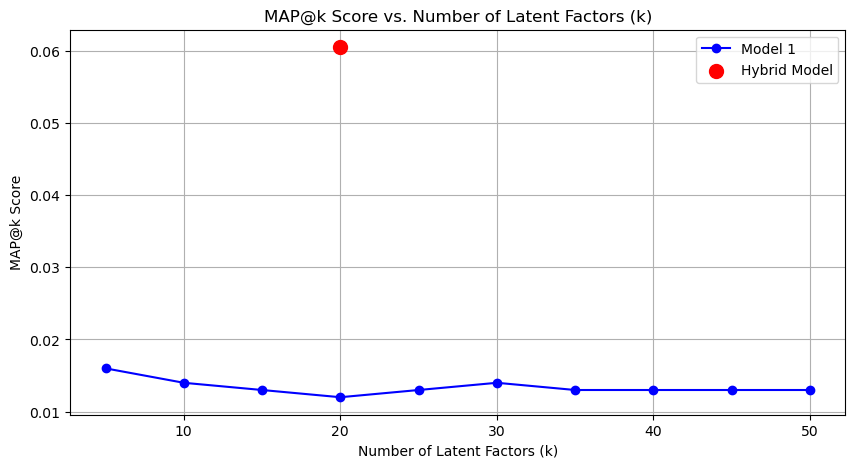

In [72]:
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
map_at_k_scores = [0.016, 0.014, 0.013, 0.012, 0.013, 0.014, 0.013, 0.013, 0.013, 0.013]

# Plotting the main graph
plt.figure(figsize=(10, 5))
plt.plot(k_values, map_at_k_scores, marker='o', linestyle='-', color='b', label='Model 1')

# Adding title and labels
plt.title('MAP@k Score vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('MAP@k Score')

k_value_another_model = 20
map_at_k_another_model = 0.0605
plt.scatter(k_value_another_model, map_at_k_another_model, color='r', s=100, label='Hybrid Model', zorder=5)

# Optionally, add a grid for easier reading
plt.grid(True)

# Adding a legend to distinguish between the main graph and the separate feature
plt.legend()

# Show the plot
plt.show()

In [73]:
def compute_intra_list_similarity(recommendations, cosine_sim, movies):
    # Initialize a variable to store the sum of all pairwise similarities
    total_similarity = 0
    # Initialize a counter to count the number of similarity scores added
    num_scores = 0
    
    # Convert movie IDs in recommendations to indices in the cosine similarity matrix
    indices = [movies.index[movies['movieId'] == movie_id].tolist()[0] for movie_id in recommendations]
    
    # Calculate pairwise cosine similarity for all unique pairs in the recommendation list
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            similarity = cosine_sim[indices[i], indices[j]]
            total_similarity += similarity
            num_scores += 1
    
    # Compute the average similarity
    if num_scores > 0:
        average_similarity = total_similarity / num_scores
    else:
        average_similarity = 0
    
    return average_similarity


# Compute intra-list similarity for the top k recommendations
intra_list_similarity = compute_intra_list_similarity(top_k_recommendations, cosine_sim, movies)

print("Intra-list similarity for the top", k, "recommendations:", intra_list_similarity)

Intra-list similarity for the top 10 recommendations: 0.21052121755543254
